# SWMAL Exercise

## Pipelines

We now try building af ML pipeline. The data for this exercise is the same as in L01, meaning that the OECD data from the 'intro.ipynb' have been save into a Python 'pickle' file. 

The pickle library is a nifty data preservation method in Python, and from L01 the tuple `(X, y)` have been stored to the pickle file `itmal_l01_data.pkl', try reloading it..

In [71]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "Data/itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

Using the MLP for the QECD data in Qd) from `intro.ipynb` produced a negative $R^2$, meaning that it was unable to fit the data, and the MPL model was actually _worse_ than the naive $\hat y$ (mean value of y).

Let's just revisit this fact. When running the next cell you should now see an OK $~R^2_{lin.reg}~$ score and a negative $~R^2_{mlp}~$ score..

The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..



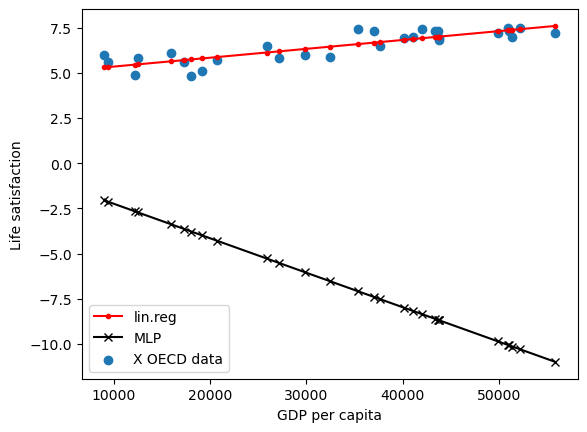

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-272.85

OK


In [72]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])
    plt.show()

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

Now, the neurons in neural networks normally expect input data in the range `[0;1]` or sometimes in the range `[-1;1]`, meaning that for value outside this range then the neuron will saturate to its min or max value (also typical `0` or `1`). 

A concrete value of `X` is, say 22.000 USD, that is far away from what the MLP expects. Af fix to the problem in Qd), from `intro.ipynb`, is to preprocess data by scaling it down to something more sensible.

Try to manually scale X to a range of `[0;1]`, re-train the MLP, re-plot and find the new score from the rescaled input. Any better?

(If you already made exercise "Qe) Neural Network with pre-scaling" in L01, then reuse Your work here!) 

In [73]:
# TODO: add your code here..
#assert False, "TODO: rescale X and refit the model(s).."

X_min = np.min(X)
X_max = np.max(X)
s = X_max - X_min

print(f"X_min={X_min:.0f}, X_max={X_max:.0f}, s={s:.0f}")

X_scaled = (X - X_min) / s
print(f"X_scaled.shape={X_scaled.shape}")
print(f"np.min(X_scaled)={np.min(X_scaled)}")
print(f"np.max(X_scaled)={np.max(X_scaled)}")

mlp.fit(X_scaled, y)
y_pred_mlp = mlp.predict((M-X_min)/s)

#plt.plot(m, y_pred_lin, "r")
plt.plot(m, y_pred_mlp, "k.")

print(f"mlp.score={mlp.score(X_scaled, y):0.2f}")

X_min=9055, X_max=55805, s=46750
X_scaled.shape=(29, 1)
np.min(X_scaled)=0.0
np.max(X_scaled)=1.0
mlp.score=0.72


### Qb) Scikit-learn Pipelines

Now, rescale again, but use the `sklearn.preprocessing.MinMaxScaler`.

When this works put both the MLP and the scaler into a composite construction via `sklearn.pipeline.Pipeline`. This composite is just a new Scikit-learn estimator, and can be used just like any other `fit-predict` models, try it, and document it for the journal.

(You could reuse the `PlotModels()` function by also retraining the linear regressor on the scaled data, or just write your own plot code.)

In [74]:
# TODO: add your code here..
#assert False, "TODO: put everything into a pipeline.."

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(
    [
        ('scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
pipe.fit(X,y)

print(f"pipe.score(..)={pipe.score(X,y):0.2f}")


pipe.score(..)=0.73


### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler

Explain the fundamental problem with a min-max scaler and outliers. 

Will a `sklearn.preprocessing.StandardScaler` do better here, in the case of abnormal feature values/outliers?

The general problem with normal scalers are that they are largely affected by outliers. lets say we have a system that generally swings between 1 and 10, but then you have an outlier of 100 then the max value would be 100 and all the other number would range from 0-0.1 which is not a lot. So this looses some sensitivity. 

The standard scaler is a litte better at this but still affected because it centers around the mean instead of the min and max. 

In [75]:
# TODO: research the problem here..
#assert False, "TODO: investigate outlier problems and try a StandardScaler.."

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define test data (reshaped for sklearn compatibility)
X_test = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]).reshape(-1, 1)

# Define a pipeline with StandardScaler
pipe_standard = Pipeline([
    ('transformer', StandardScaler())  # StandardScaler is a transformer
])

# Define a pipeline with StandardScaler
pipe_minmax = Pipeline([
    ('transformer', MinMaxScaler())  # StandardScaler is a transformer
])

"""
in this example we dont want to make predictions but only test the transformation of the data
So it is not nessesarily better to use pipeline since they only do one thing but we use them
just for the understanding
"""


# Fit and transform the data
X_scaled_standard = pipe_standard.fit_transform(X_test)
X_scaled_minmax = pipe_minmax.fit_transform(X_test)

# Print results
print("Original X_test:", X_test.ravel())  # Flatten for readability
print("Transformed X_test:", X_scaled_standard.ravel())  # Scaled values
print("Mean of Scaled Data:", X_scaled_standard.mean())  # Should be ~0
print("Standard Deviation of Scaled Data:", X_scaled_standard.std())  # Should be ~1

print("Transformed X_test:", X_scaled_minmax.ravel())  # Scaled values
print("Mean of Scaled Data:", X_scaled_minmax.mean())  # Should be ~0
print("Standard Deviation of Scaled Data:", X_scaled_minmax.std())  # Should be ~1

Original X_test: [  1   2   3   4   5   6   7   8   9  10 100]
Transformed X_test: [-0.47944098 -0.44281701 -0.40619305 -0.36956909 -0.33294512 -0.29632116
 -0.2596972  -0.22307323 -0.18644927 -0.14982531  3.14633142]
Mean of Scaled Data: 0.0
Standard Deviation of Scaled Data: 1.0
Transformed X_test: [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 1.        ]
Mean of Scaled Data: 0.1322314049586777
Standard Deviation of Scaled Data: 0.275803302177393


Here you can see that the standard ranges in the non outliers from -0.48 to -0.14 which is a range of 0.34 and the minmax ranges from 0-0.09 which is a way smaller range. But the outlier is outside the range of -1 - 1 so that could be a problem.

### Qd) Modify the MLP Hyperparameters

Finally, try out some of the hyperparameters associated with the MLP.

Specifically, test how few neurons the MLP can do with---still producing a sensible output, i.e. high $R^2$. 

Also try-out some other activation functions, ala sigmoid, and solvers, like `sgd`.

Notice, that the Scikit-learn MLP does not have as many adjustable parameters, as a Keras MLP, for example, the Scikit-learn MLP misses neurons initialization parameters (pp.333-334 2nd./pp.358-359 3rd. [HOML]) and the ELU activation function (p.336 2nd./ p.363 3rd. [HOML]).

[OPTIONAL 1]: use a Keras MLP regressor instead of the Scikit-learn MLP (You need to install the  Keras if its not installed as default).

[OPTIONAL 2]: try out the `early_stopping` hyperparameter on the `MLPRegressor`. 

[OPTIONAL 3]: try putting all score-calculations into K-fold cross-validation  methods readily available in Scikit-learn using

* `sklearn.model_selection.cross_val_predict`
* `sklearn.model_selection.cross_val_score` 

or similar (this is, in theory, the correct method, but can be hard to use due to the  extremely small number of data points, `n=29`).

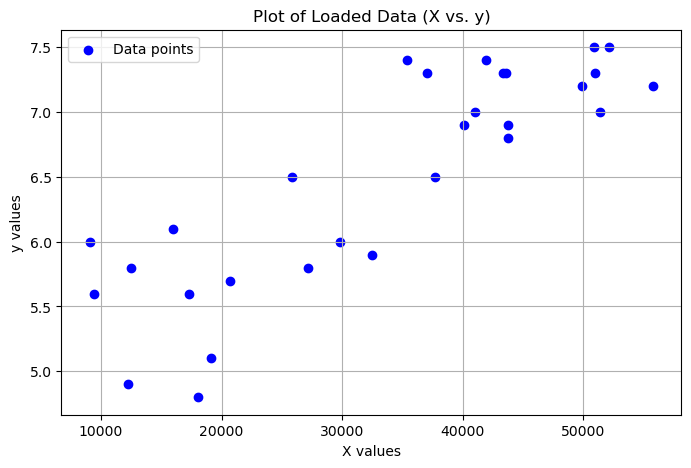

not scaled R² Score: -1012285.9361
Scaled R² Score: 0.7183
Neurons: 1, R² Score: -0.6193
Neurons: 5, R² Score: -0.4903
Neurons: 10, R² Score: -0.1296
Neurons: 50, R² Score: 0.2947
Neurons: 100, R² Score: 0.2861


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import GridSearchCV

def make_pipeline(neurons = 1, max_iteration = 5000):
    return Pipeline(
        [
            ('transformer', MinMaxScaler()),
            ('estimator', MLPRegressor(hidden_layer_sizes=(neurons,),max_iter=max_iteration))
        ]
    )

#Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Data points")  # Scatter plot of X vs y
plt.xlabel("X values")
plt.ylabel("y values")
plt.title("Plot of Loaded Data (X vs. y)")
plt.legend()
plt.grid(True)
plt.show()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the MLP Regressor with default settings
mlp = MLPRegressor(max_iter=5000)

# Train the model
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"not scaled R² Score: {r2:.4f}")

# now lets scale the data
# for this we can use a pipeline to make the implimentation more streamline and user friendly
pipeline_standart = Pipeline(
    [
        ('transformer', MinMaxScaler()),
        ('estimator', MLPRegressor(max_iter=5000))
    ]
)
# Fit the pipeline on training data
pipeline_standart.fit(X_train, y_train)

# Predict on the test set
y_pred_standard = pipeline_standart.predict(X_test)

# Compute R² score
r2_standard = r2_score(y_test, y_pred_standard)

print(f"Scaled R² Score: {r2_standard:.4f}")

# testing different neurons
# From definition in mlpregressor
"""
    hidden_layer_sizes : array-like of shape(n_layers - 2,), default=(100,)
        The ith element represents the number of neurons in the ith
        hidden layer.
"""




REVISIONS||
:-|:-|
2020-10-15| CEF, initial. 
2020-10-21| CEF, added Standard Scaler Q.
2020-11-17| CEF, removed orhpant text in Qa (moded to Qc).
2021-02-10| CEF, updated for ITMAL F21.
2021-11-08| CEF, updated print info.
2021-02-10| CEF, updated for SWMAL F22.
2023-02-19| CEF, updated for SWMAL F23, adjuste page numbers for 3rd.ed.
2023-02-21| CEF, added types, rewrote CalcPredAndScore and added isNumpyData.
2024-09-11| CEF, updated page refefences.